# Question 1.a

In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

torch.set_printoptions(precision=10)
torch.__version__

'0.3.1.post2'

## Load train and test dataset

In [3]:
class OccupancyDataset(Dataset):
    """ Occupancy detection dataset"""
    
    def __init__(self, filename):
        self.dataset = np.loadtxt(filename, skiprows=1, dtype = object, delimiter=',')
        
        self.data = np.array(self.dataset[:,2:7], dtype = float)
        self.data = (self.data - self.data.mean())/self.data.std()
        self.data = torch.from_numpy(self.data).float()
        
        self.target = np.array(self.dataset[:,7], dtype = float)
        self.target = torch.from_numpy(self.target).float()
        
    def __len__(self):
        return self.data.size()[0]
    
    def __getitem__(self, idx):
        return (self.data[idx, :], self.target[idx])

train_dataset = OccupancyDataset('train_data.txt')
test_dataset = OccupancyDataset('test_data.txt')

train_loader = DataLoader(train_dataset, batch_size = len(train_dataset), shuffle = False)
test_loader = DataLoader(test_dataset, batch_size= len(test_dataset), shuffle = False)

## Create network class

In [4]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(5,5)
        self.fc2 = nn.Linear(5,1)
        
    def forward(self, x):
        #print(x)
        x = F.sigmoid(self.fc1(x))
        return F.sigmoid(self.fc2(x))
    
n = Net()
print(n)
#print(list( n.parameters()) )

Net(
  (fc1): Linear(in_features=5, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=1, bias=True)
)


## Setting variables

In [5]:
net = Net()
print(list(net.parameters()))
epochs = 1000
lr = 0.0001
optimizer = optim.SGD(net.parameters(), lr=lr)
criterion = nn.BCELoss()

[Parameter containing:
-0.0626391768 -0.2261362970 0.4195485711 -0.0486054122 -0.2265023887
-0.3636805415 -0.2692025304 -0.0628432333 -0.1871821582 -0.3877520263
-0.3966715038 -0.1359688342 -0.2388937026 -0.2793056965 0.3231502175
0.1630388498 0.1343439817 -0.1807719171 -0.2309059501 -0.3681155145
0.0247140229 -0.4450216591 0.3383305073 0.3403561115 -0.3957799673
[torch.FloatTensor of size 5x5]
, Parameter containing:
-0.2410348654
-0.4041354060
-0.0552471280
0.2703957558
-0.1516707540
[torch.FloatTensor of size 5]
, Parameter containing:
0.2509794235 0.3994463682 0.0853349566 0.1052467227 0.0558738708
[torch.FloatTensor of size 1x5]
, Parameter containing:
-0.4326401055
[torch.FloatTensor of size 1]
]


## Train function

In [6]:
def train(epoch):
    for i, data in enumerate(train_loader, 0):
        optimizer.zero_grad()
        inputs, target = data
        inputs, target = Variable(inputs), Variable(target.float())
        #print(input)
        #print(target)
        output = net(inputs).squeeze()
        #print(output)
        #output = torch.round(output).squeeze()
        loss =  criterion(output, target)     
        loss.backward()
        optimizer.step()

    return loss.data[0]
    
    
def get_acc(loader, dataset):
    correct = 0
    total = 0
    for i, data in enumerate(loader, 0):
        inputs, target = data
        inputs, target = Variable(inputs), Variable(target.float())
        output = net(inputs).squeeze()
        #print('Output 1: {0}'.format(output))
        output = output>0.5
        #print('Output 2: {0}'.format(output))
        
        #print('Target: {0}'.format(target))
        correct += (target.data.cpu().numpy() == output.data.cpu().numpy()).sum()
        #print('Matching: {0}'.format((target == output).sum()))
        total += target.size(0)
    #return accuracy_score(target.data.cpu().numpy(), output.data.cpu().numpy())*100
    return 100*int(correct)/int(total)
    

In [6]:
losses = []
for i in range(epochs):
    loss = train(i)
    losses.append(loss)
    train_acc = get_acc(train_loader, 'Train')
    test_acc = get_acc(test_loader, 'Test')
    if i%100==0:
        print('\n')
        print('Loss after epoch {1}: {0}'.format(loss, i))
        print('Train Accuracy: {0}'.format(train_acc))
        print('Test Accuracy: {0}'.format(test_acc))
        



Loss after epoch 0: 0.5367335081100464
Train Accuracy: 78.76703917475132
Test Accuracy: 78.98892534864643


Loss after epoch 100: 0.5364893674850464
Train Accuracy: 78.76703917475132
Test Accuracy: 78.98892534864643


Loss after epoch 200: 0.5362662672996521
Train Accuracy: 78.76703917475132
Test Accuracy: 78.98892534864643


Loss after epoch 300: 0.5360569357872009
Train Accuracy: 78.76703917475132
Test Accuracy: 78.98892534864643


Loss after epoch 400: 0.535822868347168
Train Accuracy: 78.76703917475132
Test Accuracy: 78.98892534864643


Loss after epoch 500: 0.5356074571609497
Train Accuracy: 78.76703917475132
Test Accuracy: 78.98892534864643


Loss after epoch 600: 0.535388708114624
Train Accuracy: 78.76703917475132
Test Accuracy: 78.98892534864643


Loss after epoch 700: 0.5351848006248474
Train Accuracy: 78.76703917475132
Test Accuracy: 78.98892534864643


Loss after epoch 800: 0.5349476933479309
Train Accuracy: 78.76703917475132
Test Accuracy: 78.98892534864643


Loss after e

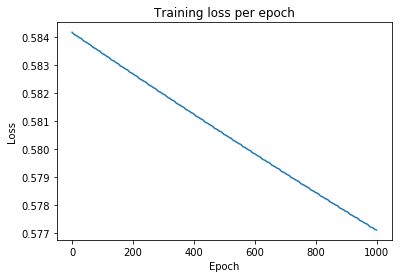

In [122]:
plt.figure()
plt.title('Training loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(epochs), losses)

# Question 1.b

## Check accuracy for random output on test dataset

In [7]:
# Generate 5 trials of random input
random_pred_5 = np.random.randint(0,2, (len(train_dataset), 5))
random_pred = np.zeros(len(train_dataset))

# Find the maximum occuring value 
for i in np.arange(len(train_dataset)):
    un = np.unique(random_pred_5[i,:], return_counts = True)
    random_pred[i] = np.argmax(un[1])
    
#print(random_pred)

# Get the test dataset output
dataset = np.loadtxt('train_data.txt', skiprows=1, dtype = object, delimiter=',')
target = np.array(dataset[:,7], dtype = int)

# Get accuracy
print('Accuracy using random predictions on train dataset: {0}'.format(accuracy_score(target, random_pred)*100))


output = Variable(torch.from_numpy(random_pred).float())
target = Variable(torch.from_numpy(target).float())
print('Baseline BCE training loss: {0}'.format(F.binary_cross_entropy(output, target)))

print('Baseline MSE training loss: {0}'.format(F.mse_loss(output, target)))

Accuracy using random predictions on train dataset: 52.572761881370496
Baseline BCE training loss: Variable containing:
13.1051988602
[torch.FloatTensor of size 1]

Baseline MSE training loss: Variable containing:
0.4742723703
[torch.FloatTensor of size 1]



## Check accuracy for random output on test dataset

In [125]:
# Generate 5 trials of random input
random_pred_5 = np.random.randint(0,2, (len(test_dataset), 5))
random_pred = np.zeros(len(test_dataset))

# Find the maximum occuring value 
for i in np.arange(len(test_dataset)):
    un = np.unique(random_pred_5[i,:], return_counts = True)
    random_pred[i] = np.argmax(un[1])
    
#print(random_pred)

# Get the test dataset output
dataset = np.loadtxt('test_data.txt', skiprows=1, dtype = object, delimiter=',')
target = np.array(dataset[:,7], dtype = int)

# Get accuracy
print('Accuracy using random predictions on test dataset: {0}'.format(accuracy_score(target, random_pred)*100))

Accuracy using random predictions on test dataset: 51.86628383921247
